In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/icb/ignacio.ibarra/miniconda3/envs/multibind/bin/python'

In [3]:
import numpy as np
import pandas
import multibind

/home/icb/ignacio.ibarra/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [5]:
data = mb.bindome.datasets.SELEX.get_data()

PRJEB9797
# filenames 5881
PRJEB14744
# filenames 487
PRJEB20112
# filenames 789
PRJEB3289
# filenames 2731


In [6]:
# data_sel = data[data['filename'].str.contains('GATA') | data['filename'].str.contains('FOXA1')]
# read_tf = mb.bindome.datasets.SELEX.load_read_counts('GATA4', data)
# read_tf = mb.bindome.datasets.SELEX.load_read_counts(log_each=50, n_sample=100) #  stop_at=50)
# df = mb.bindome.datasets.ProBound.GR_mult_conc()
# df = df.sort_values(1, ascending=False).reset_index(drop=True)

In [11]:
tf_name = 'ELK1'
data_sel_tf = data[(data['tf.name'] == tf_name)] #  & (grp['cycle'].astype(str) == '1')]
data_sel_zero = data[(data['cycle'] == 0) & data['library'].isin(set(data[data['tf.name'] == tf_name]['library']))]  # & grp['accession'].isin(set(grp[grp['tf.name'] == tf]['accession']))]

data_sel = pd.concat([data_sel_tf, data_sel_zero]).reset_index(drop=True)
data_sel.shape
# print(data_sel_tf.shape[0], data_sel_zero.shape[0])
# print('loading', tf, ':', library)
# reads_tf = mb.bindome.datasets.SELEX.load_read_counts(tf, data=data_sel_tf)
# reads_zero = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel_zero, library=library)

(43, 7)

In [12]:
# data_sel = data[data['accession'] != 'cardiac_complexes'] # .head(4)
# data_sel = data_sel.head(5)

# data_sel = data[data['tf.name'].str.contains('ELK1')].reset_index(drop=True)
data_sel['cycle'] = data_sel['cycle'].astype(int)
# data_sel['cycle']

In [13]:
import scanpy as sc
import anndata
import os

In [14]:
data_sel.shape

(43, 7)

In [15]:
# loading with the fastest command takes about 5 minutes
k = 11
adata_kmers_bkp = '../../data/kmers_adata_%s_k%i.h5ad' % (tf_name, k)
if True or not os.path.exists(adata_kmers_bkp):
    kmers_by_k = {}
    for ri, r in data_sel.iterrows():
        if ri % 5 == 0:
            print('%i out of %i' % (ri, data_sel.shape[0]))
        key_added = r['filename'].replace('.fastq.gz', '').replace('.txt.gz', '')    

        # print(r['path'])
        df_kmers = None
        if mb.bindome.datasets.SELEX.is_fastq(r['path']) and k >= 10:
            df_kmers = mb.tl.fastq2kmers(r['path'], k) # 
            df_kmers[df_kmers.columns[0]] = pd.arrays.SparseArray(df_kmers[df_kmers.columns[0]])
        else:
            read_tf = mb.bindome.datasets.SELEX.load_read_counts(data=data_sel[data_sel.index == ri], log_each=50, n_sample=100)
            next_df = read_tf[list(read_tf.keys())[0]]
            df_kmers = mb.tl.seqs2kmers(next_df['seq'], k, counts=next_df['counts'])

        df_kmers.columns = [key_added]
        
        # convert to sparse
        df_kmers[df_kmers.columns[0]] = pd.arrays.SparseArray(df_kmers[df_kmers.columns[0]])
        kmers_by_k[key_added] = df_kmers

        if len(kmers_by_k.keys()) % 25 == 0:
            print(len(kmers_by_k.keys()), 'out of', data_sel.shape[0])

        import warnings
        warnings.filterwarnings("ignore")

    from functools import reduce
    print('merging...')
    df_merged = reduce(lambda  left,right: pd.merge(left, right, left_index=True, right_index=True,
                                                how='outer'), kmers_by_k.values()).fillna(0)
    print('merging done...')
    
    print('transposing...')
    df_merged = df_merged.T
    
    # df_merged
    
    print('convert to anndata...')
    adata = anndata.AnnData(df_merged)
    data_sel.index = adata.obs_names
    
    adata.obs = data_sel
    adata.var_names = list(adata.var_names)
    
    print('writing')
    adata.write(adata_kmers_bkp, compression='lzf')
    print('writing done...')
    
print('reading adata')
adata = sc.read_h5ad(adata_kmers_bkp)
print('done...')

0 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


5 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


10 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


15 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


20 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


25 out of 43
25 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


30 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


35 out of 43


in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 
in1: 100% 


40 out of 43


in1: 100% 
in1: 100% 
in1: 100% 


merging...
merging done...
transposing...
convert to anndata...
writing
writing done...
reading adata
done...


In [16]:
adata.shape

(43, 2097152)

In [17]:
!ls -ltrh $adata_kmers_bkp

-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 319M May 28 17:59 ../../data/kmers_adata_ELK1_k11.h5ad


In [18]:
size = 0
for p in data_sel['path']:
    size += os.path.getsize(p) / 1e6
print(size)

387.255515


In [5]:
# # %load_ext line_profiler
# %lprun -f get_kmers get_kmers(next_df['seq'], 6, counts=next_df['counts'])
# %time kmers = get_kmers(next_df['seq'], 6, counts=next_df['counts'])

In [31]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 2

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [7]:
sc.set_figure_params(facecolor='white')

In [8]:
import seaborn as sns

In [34]:
adata

AnnData object with n_obs × n_vars = 309 × 524800
    obs: '_index', 'batch', 'cycle', 'filename', 'library', 'is.zero', 'tf.name', 'accession'
    uns: 'neighbors', 'umap', 'tf.name_colors', 'is.zero_colors', 'accession_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [35]:
adata.obs

,_index,batch,cycle,filename,library,is.zero,tf.name,accession
_index,,,,,,,,
ZeroCycle_ES0_TCCGTG20NTGC_0,ZeroCycle_ES0_TCCGTG20NTGC_0,ES0,,ZeroCycle_ES0_TCCGTG20NTGC_0.txt.gz,TCCGTG20NTGC,True,ZEROCYCLE,PRJEB14744
ZeroCycle_ES0_TCGGAA20NAGT_0,ZeroCycle_ES0_TCGGAA20NAGT_0,ES0,,ZeroCycle_ES0_TCGGAA20NAGT_0.txt.gz,TCGGAA20NAGT,True,ZEROCYCLE,PRJEB14744
ZeroCycle_ES0_TCGGGG20NGGT_0,ZeroCycle_ES0_TCGGGG20NGGT_0,ES0,,ZeroCycle_ES0_TCGGGG20NGGT_0.txt.gz,TCGGGG20NGGT,True,ZEROCYCLE,PRJEB14744
ZeroCycle_ES0_TCTATG20NTAG_0,ZeroCycle_ES0_TCTATG20NTAG_0,ES0,,ZeroCycle_ES0_TCTATG20NTAG_0.txt.gz,TCTATG20NTAG,True,ZEROCYCLE,PRJEB14744
ZeroCycle_ES0_TCTCTT20NGA_0,ZeroCycle_ES0_TCTCTT20NGA_0,ES0,,ZeroCycle_ES0_TCTCTT20NGA_0.txt.gz,TCTCTT20NGA,True,ZEROCYCLE,PRJEB14744
...,...,...,...,...,...,...,...,...
FOXA1_FL_2_KX_TCCCAT40NTGT,FOXA1_FL_2_KX_TCCCAT40NTGT,FL,,FOXA1_FL_2_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,False,FOXA1,PRJEB9797
FOXA1_FL_3_KX_TAGCGT40NTCA,FOXA1_FL_3_KX_TAGCGT40NTCA,FL,,FOXA1_FL_3_KX_TAGCGT40NTCA.fastq.gz,TAGCGT40NTCA,False,FOXA1,PRJEB9797
FOXA1_FL_3_KX_TCCCAT40NTGT,FOXA1_FL_3_KX_TCCCAT40NTGT,FL,,FOXA1_FL_3_KX_TCCCAT40NTGT.fastq.gz,TCCCAT40NTGT,False,FOXA1,PRJEB9797


In [33]:
adata.to_df()

,0,1,2,3,4,5,6,7,8,9,...,524790,524791,524792,524793,524794,524795,524796,524797,524798,524799
_index,,,,,,,,,,,,,,,,,,,,,
ZeroCycle_ES0_TCCGTG20NTGC_0,137.0,137.0,108.0,117.0,137.0,107.0,104.0,85.0,129.0,93.0,...,66.0,49.0,31.0,24.0,42.0,33.0,10.0,42.0,17.0,31.0
ZeroCycle_ES0_TCGGAA20NAGT_0,79.0,72.0,80.0,85.0,83.0,51.0,42.0,59.0,85.0,59.0,...,59.0,37.0,35.0,21.0,40.0,28.0,19.0,42.0,16.0,25.0
ZeroCycle_ES0_TCGGGG20NGGT_0,94.0,72.0,65.0,89.0,86.0,43.0,57.0,51.0,70.0,48.0,...,48.0,31.0,26.0,20.0,27.0,19.0,11.0,32.0,6.0,22.0
ZeroCycle_ES0_TCTATG20NTAG_0,137.0,92.0,75.0,127.0,70.0,49.0,51.0,67.0,76.0,59.0,...,35.0,21.0,21.0,17.0,19.0,10.0,6.0,27.0,3.0,12.0
ZeroCycle_ES0_TCTCTT20NGA_0,7.0,12.0,6.0,7.0,12.0,5.0,11.0,12.0,3.0,13.0,...,10.0,7.0,4.0,3.0,3.0,4.0,0.0,4.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOXA1_FL_2_KX_TCCCAT40NTGT,14.0,22.0,6.0,14.0,35.0,19.0,16.0,13.0,9.0,8.0,...,2.0,5.0,4.0,0.0,10.0,6.0,5.0,10.0,4.0,2.0
FOXA1_FL_3_KX_TAGCGT40NTCA,4.0,3.0,3.0,5.0,10.0,5.0,4.0,0.0,6.0,3.0,...,2.0,0.0,0.0,2.0,2.0,28.0,0.0,4.0,2.0,0.0
FOXA1_FL_3_KX_TCCCAT40NTGT,24.0,22.0,14.0,15.0,43.0,17.0,35.0,7.0,8.0,21.0,...,3.0,16.0,11.0,3.0,8.0,7.0,6.0,10.0,5.0,3.0


/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


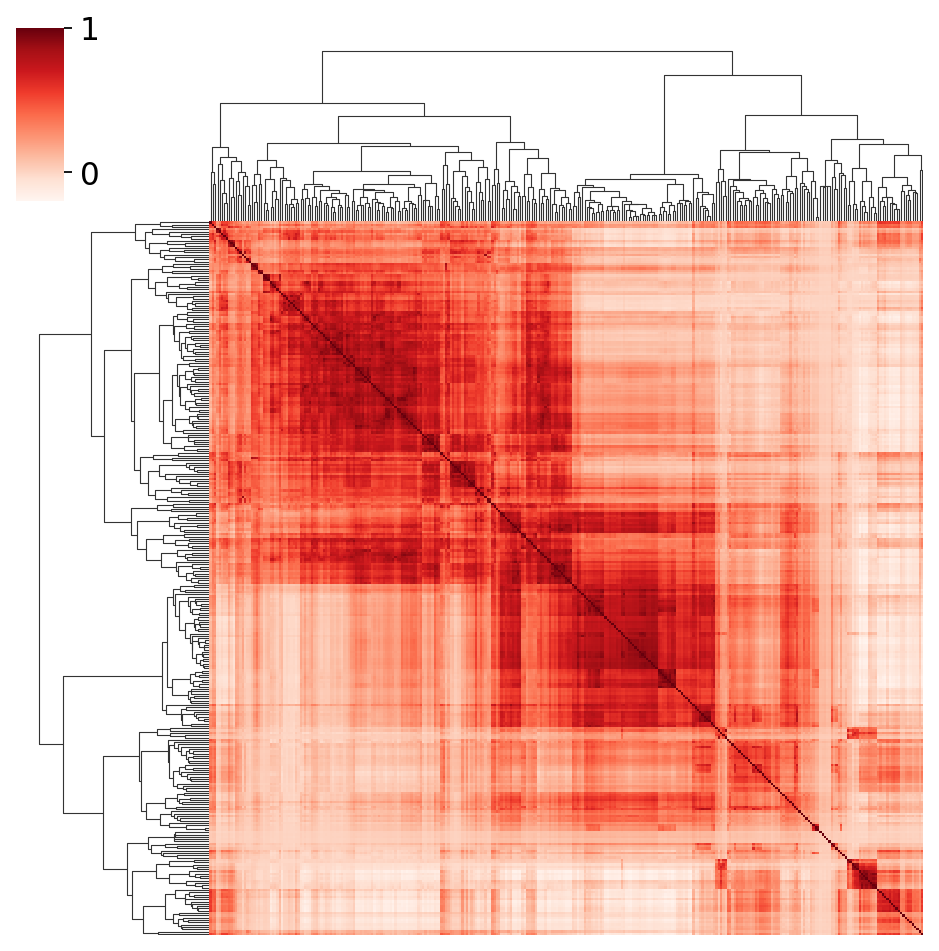

In [9]:
g = sns.clustermap(adata.to_df().T.corr(), cmap='Reds', figsize=[6, 6], xticklabels=False, yticklabels=False)

In [11]:
import pandas as pd

In [12]:
adata.obs_names = adata.obs['_index']
adata.obs['is.zero'] = pd.Categorical(adata.obs_names.str.contains('Zero'))

In [26]:
adata.obs['tf.name'] = list(data_sel['tf.name'])
adata.obs['accession'] = list(data_sel['accession'])

In [27]:
adata.obs['tf.name'].value_counts()

ZEROCYCLE    70
ELK1         38
ELK3         28
ETV4         28
ELF2         24
EGR1         23
ELF3         20
ELF4         16
FOXA1        16
ALX4         12
ETV5         12
ETS1         10
ALX1          8
ETV6          4
Name: tf.name, dtype: int64

In [28]:
for tf in set(adata.obs['tf.name']):
    print(tf, len(set(adata.obs[adata.obs['tf.name'] == tf]['accession'])))

ALX4 2
FOXA1 1
ZEROCYCLE 3
ETV5 2
EGR1 2
ELK3 2
ALX1 1
ELF3 2
ETV4 2
ETS1 1
ELF4 1
ETV6 1
ELF2 1
ELK1 2


In [29]:
adata[adata.obs['tf.name'] == 'ELK1',:].obs

,_index,batch,cycle,filename,library,is.zero,tf.name,accession
_index,,,,,,,,
ELK1_TAGCAG30NACT_AI_1,ELK1_TAGCAG30NACT_AI_1,AI,,ELK1_TAGCAG30NACT_AI_1.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TAGCAG30NACT_AI_2,ELK1_TAGCAG30NACT_AI_2,AI,,ELK1_TAGCAG30NACT_AI_2.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TAGCAG30NACT_AI_3,ELK1_TAGCAG30NACT_AI_3,AI,,ELK1_TAGCAG30NACT_AI_3.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TAGCAG30NACT_AI_4,ELK1_TAGCAG30NACT_AI_4,AI,,ELK1_TAGCAG30NACT_AI_4.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TAGCAG30NACT_AI_5,ELK1_TAGCAG30NACT_AI_5,AI,,ELK1_TAGCAG30NACT_AI_5.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TAGCAG30NACT_AI_6,ELK1_TAGCAG30NACT_AI_6,AI,,ELK1_TAGCAG30NACT_AI_6.fastq.gz,TAGCAG30NACT,False,ELK1,PRJEB3289
ELK1_TCGGAA20NAGT_AG_1,ELK1_TCGGAA20NAGT_AG_1,AG,,ELK1_TCGGAA20NAGT_AG_1.fastq.gz,TCGGAA20NAGT,False,ELK1,PRJEB3289
ELK1_TCGGAA20NAGT_AG_2,ELK1_TCGGAA20NAGT_AG_2,AG,,ELK1_TCGGAA20NAGT_AG_2.fastq.gz,TCGGAA20NAGT,False,ELK1,PRJEB3289
ELK1_TCGGAA20NAGT_AG_3,ELK1_TCGGAA20NAGT_AG_3,AG,,ELK1_TCGGAA20NAGT_AG_3.fastq.gz,TCGGAA20NAGT,False,ELK1,PRJEB3289


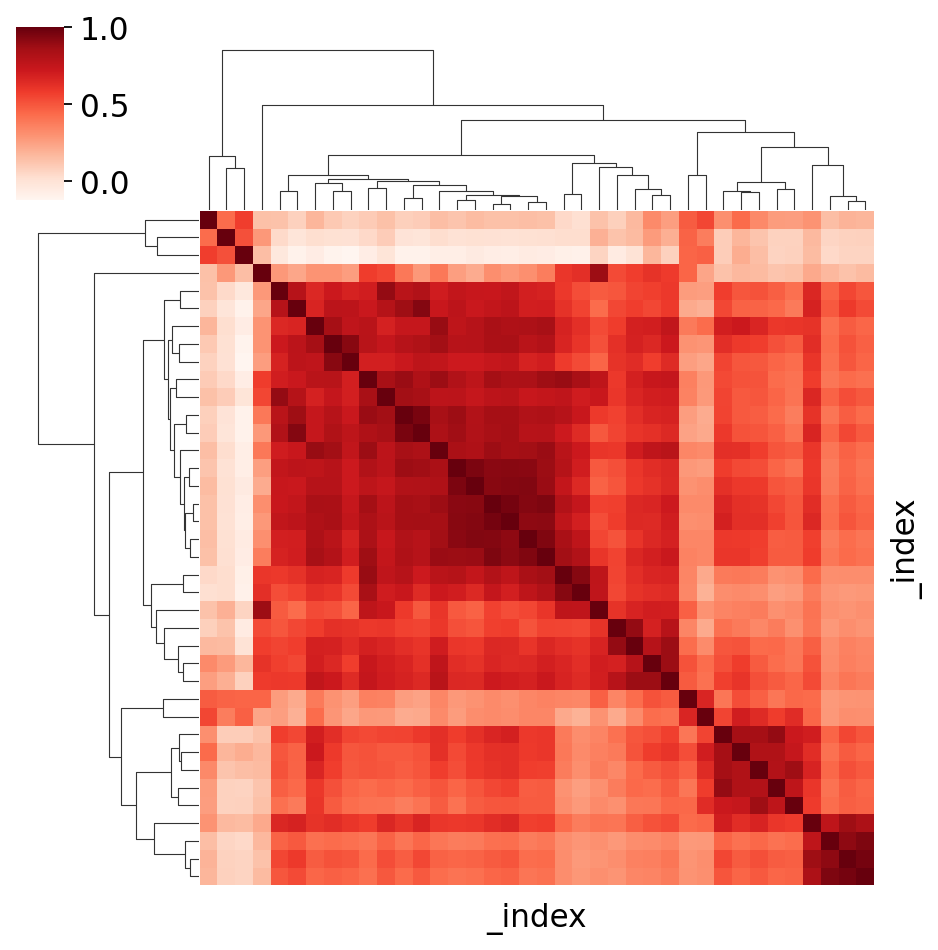

In [30]:
g = sns.clustermap(adata[adata.obs['tf.name'] == 'ELK1',:].to_df().T.corr(), cmap='Reds', figsize=[6, 6], xticklabels=False, yticklabels=False)

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


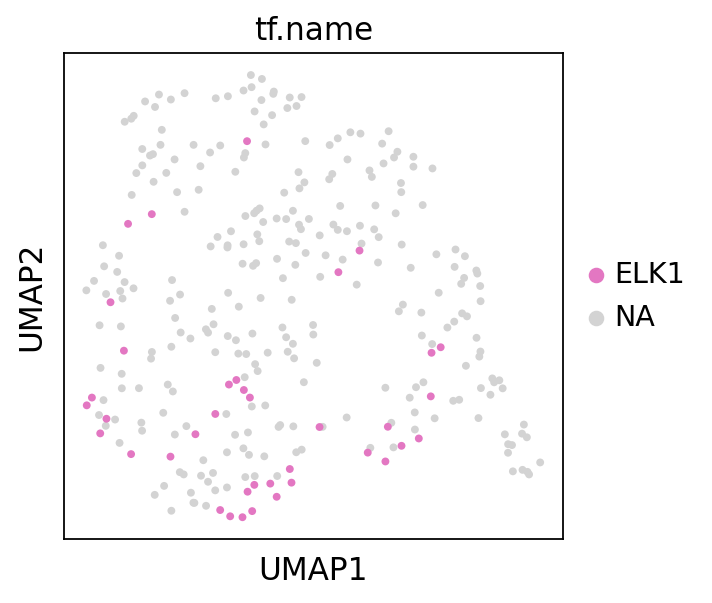

In [31]:
sc.pl.umap(adata, color=['tf.name'], groups=['ELK1'], s=50)

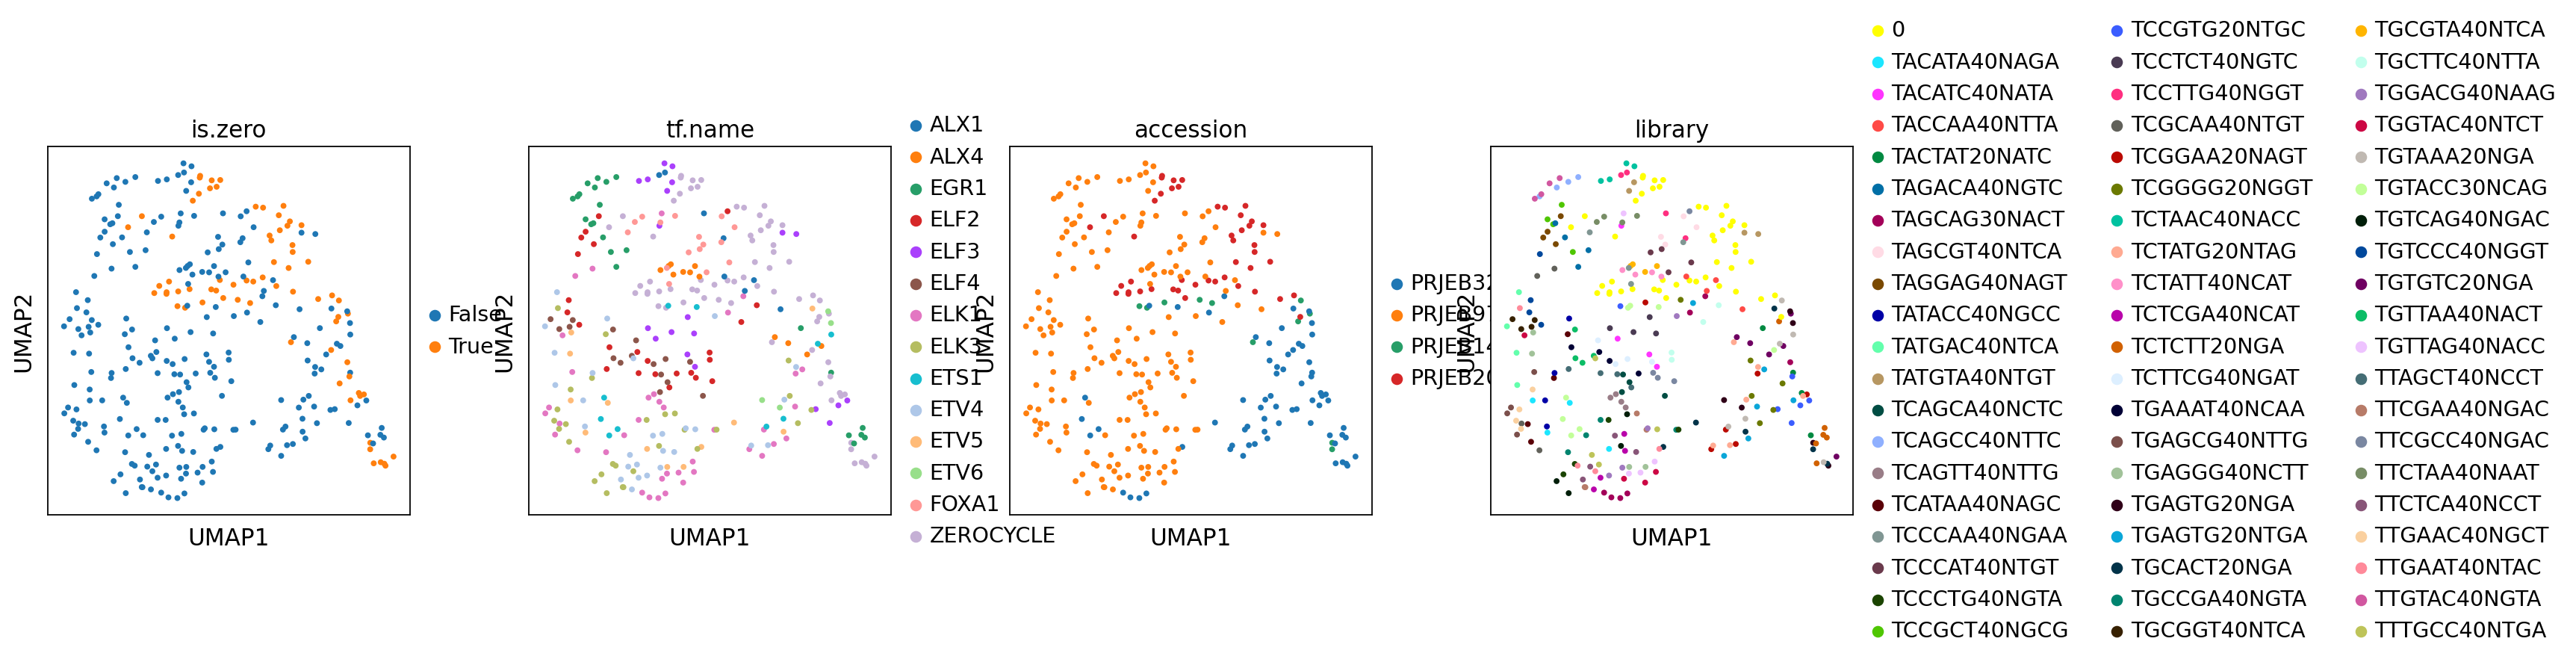

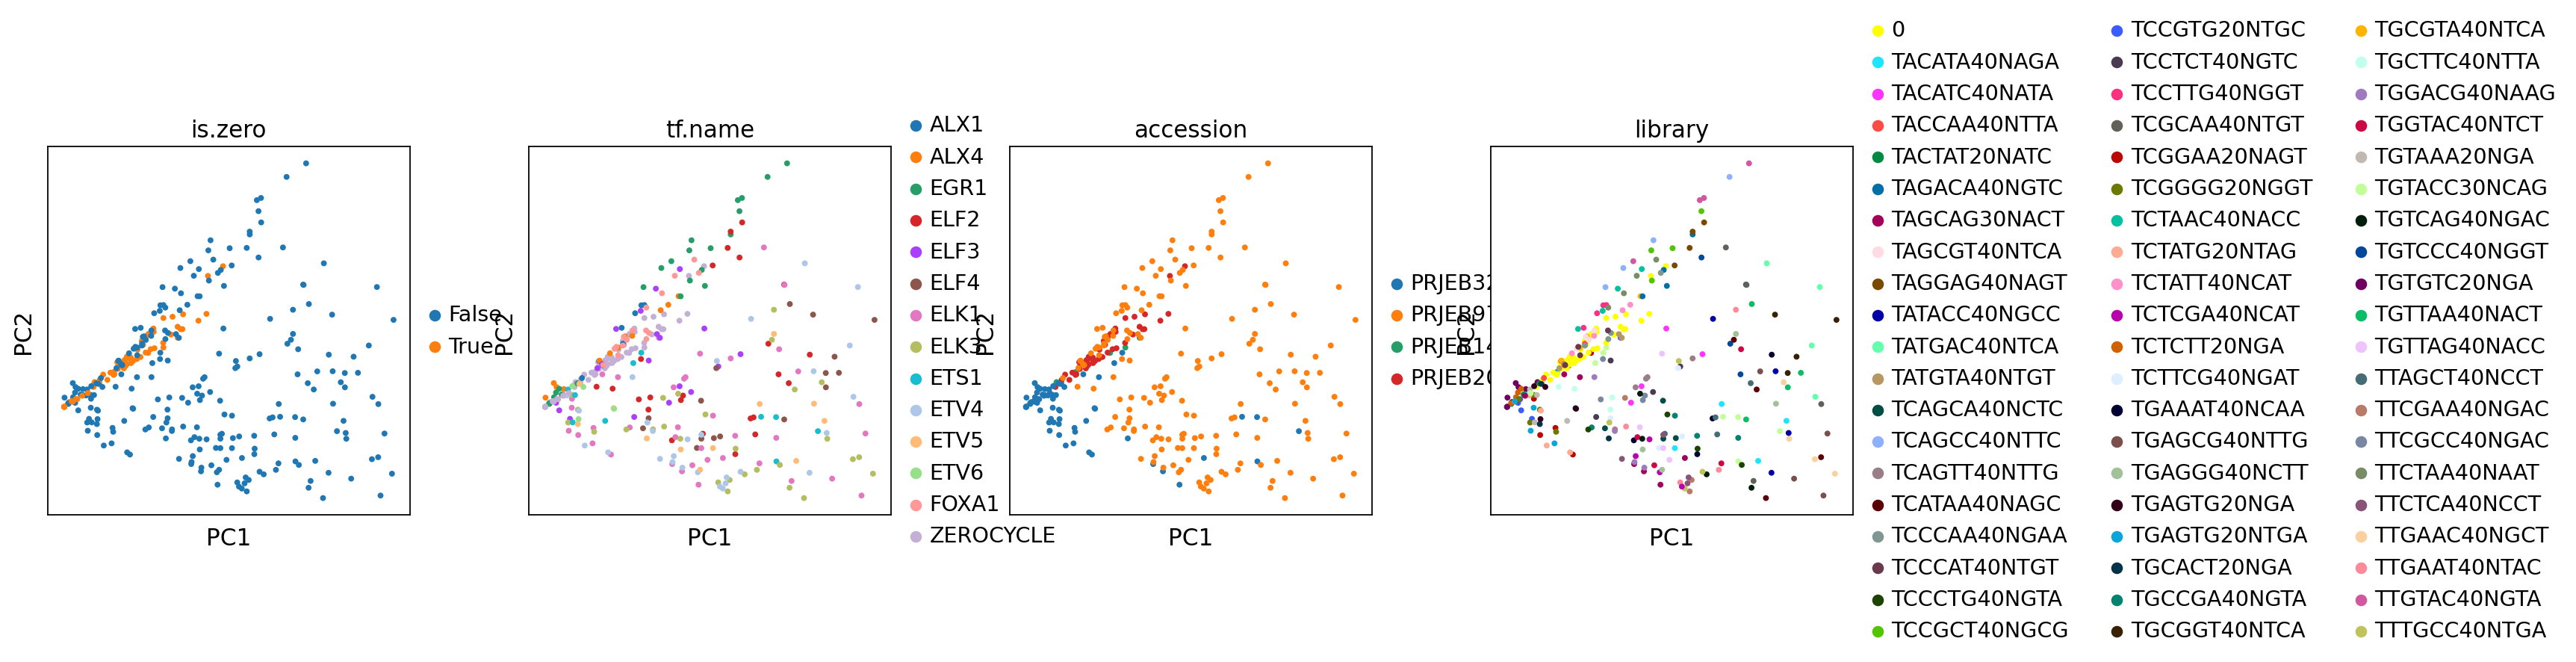

In [37]:
sc.pl.umap(adata, color=['is.zero', 'tf.name', 'accession', 'library'], s=50)
sc.pl.pca(adata, color=['is.zero', 'tf.name', 'accession', 'library'], s=50)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.executable

In [ ]:
adata.to_df()

In [8]:
import numpy as np

In [10]:
import pandas

In [12]:
import multibind

In [15]:
!which ipython

/home/rio/miniconda3/bin/ipython


In [2]:
!which ipython

/home/rio/miniconda3/bin/ipython


In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [7]:
df = mb.bindome.datasets.ProBound.GR_mult_conc()
df = df.sort_values(1, ascending=False).reset_index(drop=True)

In [8]:
data = df.head(1000)

In [9]:
n_rounds = 1

In [10]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 9, 2

/tmp/ipykernel_13907/3315481419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['batch'] = 1
/tmp/ipykernel_13907/3315481419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_count_data'] = 1


loading object (# entries) 1000


/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py:9: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "onehot_mononuc" failed type inference due to: non-precise type pyobject
During: typing of argument at /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/encoding.py (11)

File "../multibind/tl/encoding.py", line 11:
def onehot_mononuc(seq, label_encoder=LabelEncoder(), onehot_encoder=OneHotEncoder(sparse=False)):
    seq_arr = np.array(list(seq + 'ACGNT'))
    ^

  @jit
/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "onehot_mononuc" was compiled in object mode without forceobj=True.

File "../multibind/tl/encoding.py", line 10:
@jit
def onehot_mononuc(seq, label_encoder=LabelEncoder(), onehot_encoder=OneHotEncoder(sparse=False)):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/rio/min

next w 14
kernel to optimize 0
setting kernel at 0 to 1
setting kernel at 1 to 0
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


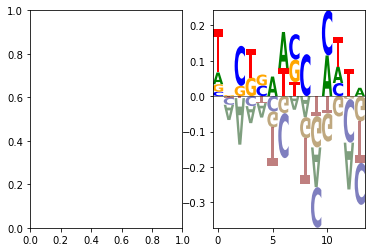

after shift optimz model


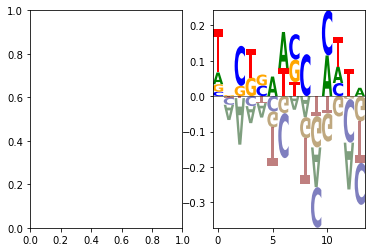


kernel to optimize 1
setting kernel at 0 to 0
setting kernel at 1 to 1
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


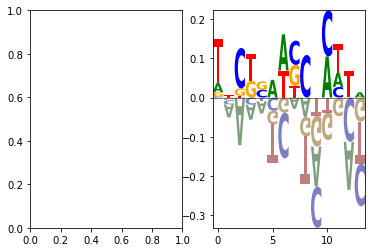

optimize_motif_shift (once)...mono grad 1 None
di grad 1 None
mono grad 1 None
di grad 1 None
nan nan nan
after shift optimz model


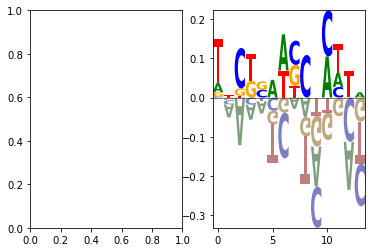


next w 16
kernel to optimize 0
setting kernel at 0 to 1
setting kernel at 1 to 0
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


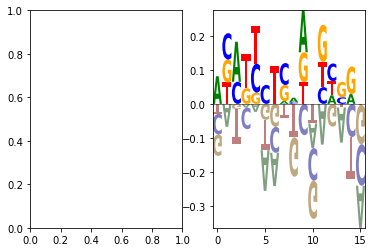

after shift optimz model


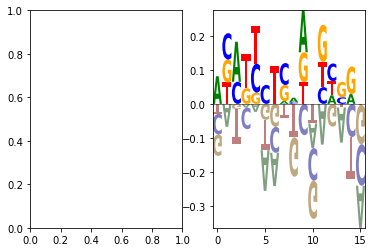


kernel to optimize 1
setting kernel at 0 to 0
setting kernel at 1 to 1
mono grad 1 None
di grad 1 None
Epoch:  1, Loss: nan
Epoch: 11, Loss: nan
before shift optim.


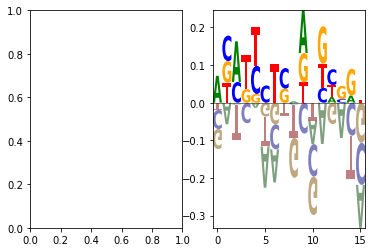

optimize_motif_shift (once)...mono grad 1 None
di grad 1 None
mono grad 1 None
di grad 1 None
nan nan nan
after shift optimz model


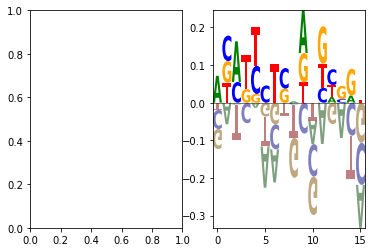

In [11]:
# assign batch and data type

data['batch'] = 1
data['is_count_data'] = 1

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, single_encoding_step=True)
train = tdata.DataLoader(dataset=dataset, batch_size=25000, shuffle=True)

model_by_k_next, res_next = mb.tl.train_iterative(train, device, min_w=16, max_w=18, n_rounds=n_rounds, n_kernels=2)                
res = []
model_by_k = {}


In [101]:
adata.obs['is.zero'] = adata.obs_names.str.contains('Zero').astype('categorical')

TypeError: data type 'categorical' not understood

In [93]:
adata

AnnData object with n_obs × n_vars = 331 × 8372
    obs: 'is.zero'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

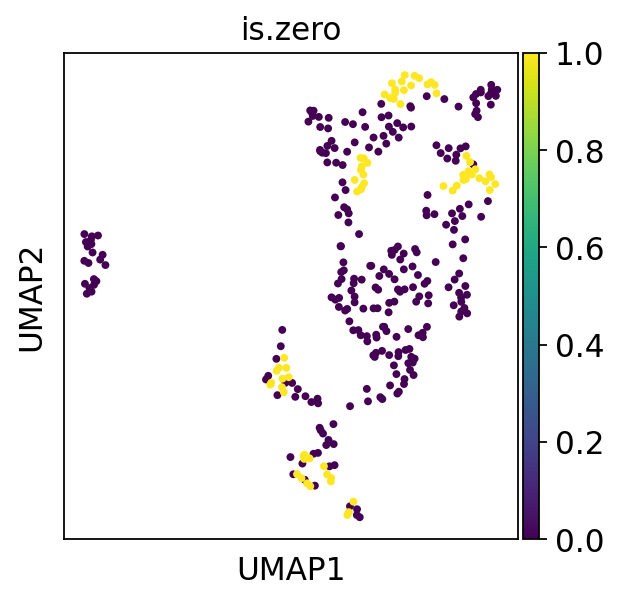

In [96]:
sc.pl.umap(adata, color='is.zero', s=50)

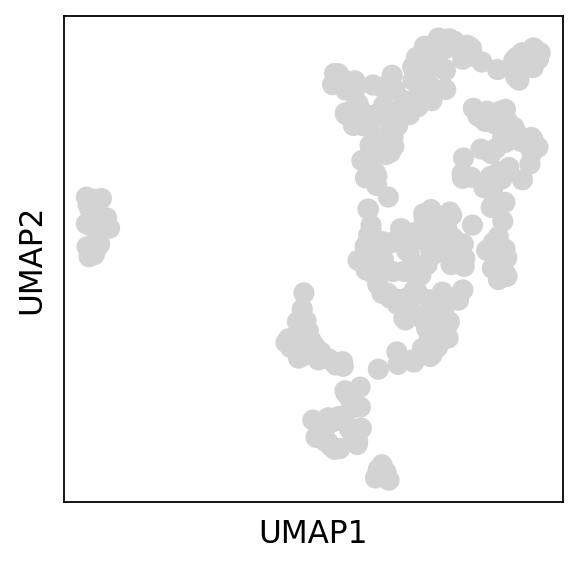

In [79]:
sc.pl.umap(adata)